# v2.0 - Random Forest with DASK

In [308]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn import preprocessing
import geopy
from geopy.distance import geodesic
import pickle
from sklearn.ensemble import RandomForestClassifier
import dask.dataframe as dd


In [309]:
import sys
sys.path.append('../references')  # Add the references folder to the system path


In [310]:
model_specs = 'RandomForest'

In [311]:
start_time_notebook = time.time()


In [408]:
# Directory to save the figures 

input_src_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/raw'
output_dir_figures_train = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/train_figures'
output_dir_figures_test = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/test_figures'

#reports_output_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'
reports_output_dir_base = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'
# reports_output_dir for DecisionTrees
reports_output_dir = f"{reports_output_dir_base}/RandomForest"
print(reports_output_dir)

/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/RandomForest


In [313]:
# Define which dataset to use
use_test_data = True  # Set to True when using fraudtest.csv

# Determine dataset type based on the variable
dataset_type = 'Test' if use_test_data else 'Train'

# Load the appropriate dataset

if use_test_data:
    output_dir_figures = output_dir_figures_test
else:
    output_dir_figures = output_dir_figures_train

In [314]:
# Generate the preprocess file name dynamically
# Get the current timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

logfile_title = 'LogFile'
logfile_name = f"{model_specs}_{dataset_type}_{logfile_title.replace(',', '').lower().split('.')[0]}_{timestamp}.txt"

logfile_path = os.path.join(reports_output_dir, logfile_name)

# Function to log times to a file
def log_time(step_name, start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    log_message = (f"{step_name} completed at {time.ctime(end_time)}. "
                   f"Elapsed time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds\n")
    
    # Append log to file
    with open(logfile_path, 'a') as f:
        f.write(log_message)
    
    # Print the message to the console as well
    print(log_message)


In [315]:
log_time(f"{model_specs}_{dataset_type} Notebook started at... ", start_time_notebook)
start_time = time.time()

Random Forest using DASK_Test Notebook started at...  completed at Sun Nov  3 13:36:56 2024. Elapsed time: 0 minutes and 0.04 seconds



# Use Dask already from the beginning


In [316]:
from dask.distributed import Client
from sklearn.ensemble import RandomForestClassifier
import dask.dataframe as dd

log_time("------Starting the DASK Client-----", start_time_notebook)

# Start Dask client
#client = Client()

from dask.distributed import Client
client = Client(dashboard_address=':0')  # Dask will pick an available port
#to avoid warning

------Starting the DASK Client----- completed at Sun Nov  3 13:36:56 2024. Elapsed time: 0 minutes and 0.05 seconds



In [317]:


# Load the dataset directly into Dask
if use_test_data:
    df_pre = dd.read_csv(f"{input_src_dir}/fraudTest.csv", assume_missing=True)
else:
    df_pre = dd.read_csv(f"{input_src_dir}/fraudTrain.csv", assume_missing=True)


# Now proceed with preprocessing, feature engineering, and model training on `df`


In [318]:
# Optionally repartition the dataset if necessary
df_pre = df_pre.repartition(npartitions=5)


# Strip whitespace from column names and rename
df_pre.columns = df_pre.columns.str.strip()
df_pre = df_pre.rename(columns={'amt': 'TransactionAmount', 'cc_num': 'CreditCardNumber', 'dob': 'DateOfBirth', 'trans_date_trans_time': 'TransactionTime'})

# Repartition to ensure consistency
df_pre = df_pre.repartition(npartitions=5)

# Preview without converting to Pandas
print("Number of partitions:", df_pre.npartitions)
print("Columns:", df_pre.columns)
print(df_pre.head())  # No .compute() here

# Final transformations or computations
# Only use .compute() at the very end if needed, for example:
df = df_pre.compute()  # Converts to Pandas for the entire dataset


Number of partitions: 5
Columns: Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
   Unnamed: 0      TransactionTime  CreditCardNumber  \
0         0.0  2020-06-21 12:14:25      2.291164e+15   
1         1.0  2020-06-21 12:14:33      3.573030e+15   
2         2.0  2020-06-21 12:14:53      3.598215e+15   
3         3.0  2020-06-21 12:15:15      3.591920e+15   
4         4.0  2020-06-21 12:15:17      3.526826e+15   

                               merchant        category  TransactionAmount  \
0                 fraud_Kirlin and Sons   personal_care               2.86   
1                  fraud_Sporer-Keebler   personal_care              29.84   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness              41.

In [319]:
print(df.columns)
print(df.shape)


Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
(555719, 23)


In [320]:
# Convert to Pandas and generate TransactionID
df = df_pre.compute()
df = df.reset_index(drop=True)
df['TransactionID'] = df.index + 1  # Unique TransactionID



In [321]:

print("Columns:", df.columns)


Columns: Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID'],
      dtype='object')


In [322]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# no missing values

Missing values per column:
 Unnamed: 0           0
TransactionTime      0
CreditCardNumber     0
merchant             0
category             0
TransactionAmount    0
first                0
last                 0
gender               0
street               0
city                 0
state                0
zip                  0
lat                  0
long                 0
city_pop             0
job                  0
DateOfBirth          0
trans_num            0
unix_time            0
merch_lat            0
merch_long           0
is_fraud             0
TransactionID        0
dtype: int64


In [323]:
# Count of fraud and non-fraud transactions
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)

# Optionally, you can get it in percentage terms
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_percentage)


is_fraud
0.0    553574
1.0      2145
Name: count, dtype: int64
is_fraud
0.0    99.614014
1.0     0.385986
Name: proportion, dtype: float64


In [324]:
#how many unique credit cards in the data set ??
df['CreditCardNumber'].nunique()

924

In [325]:
print(df.columns)

Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID'],
      dtype='object')


In [326]:
# Convert TransactionTime to datetime
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Optional: Convert DateOfBirth to datetime, if needed
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')

In [327]:
# Set 'TransactionTime' as the index permanently
df.set_index('TransactionTime', inplace=True)

# Verify the index
print(df.index)


DatetimeIndex(['2020-06-21 12:14:25', '2020-06-21 12:14:33',
               '2020-06-21 12:14:53', '2020-06-21 12:15:15',
               '2020-06-21 12:15:17', '2020-06-21 12:15:37',
               '2020-06-21 12:15:44', '2020-06-21 12:15:50',
               '2020-06-21 12:16:10', '2020-06-21 12:16:11',
               ...
               '2020-12-31 23:57:18', '2020-12-31 23:57:50',
               '2020-12-31 23:57:56', '2020-12-31 23:58:04',
               '2020-12-31 23:58:34', '2020-12-31 23:59:07',
               '2020-12-31 23:59:09', '2020-12-31 23:59:15',
               '2020-12-31 23:59:24', '2020-12-31 23:59:34'],
              dtype='datetime64[ns]', name='TransactionTime', length=555719, freq=None)


In [328]:
# Get the minimum and maximum transaction times from the index
min_time = df.index.min()
max_time = df.index.max()

print(f"Minimum Transaction Time: {min_time}")
print(f"Maximum Transaction Time: {max_time}")


Minimum Transaction Time: 2020-06-21 12:14:25
Maximum Transaction Time: 2020-12-31 23:59:34


In [329]:
df.head()

,Unnamed: 0,CreditCardNumber,merchant,category,TransactionAmount,first,last,gender,street,city,...,long,city_pop,job,DateOfBirth,trans_num,unix_time,merch_lat,merch_long,is_fraud,TransactionID
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2020-06-21 12:14:25,0.0,2.291164e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,-80.9355,333497.0,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1.371817e+09,33.986391,-81.200714,0.0,1
2020-06-21 12:14:33,1.0,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,-110.4360,302.0,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1.371817e+09,39.450498,-109.960431,0.0,2
2020-06-21 12:14:53,2.0,3.598215e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,-73.5365,34496.0,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1.371817e+09,40.495810,-74.196111,0.0,3
2020-06-21 12:15:15,3.0,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,-80.8191,54767.0,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1.371817e+09,28.812398,-80.883061,0.0,4
2020-06-21 12:15:17,4.0,3.526826e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,-85.0170,1126.0,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1.371817e+09,44.959148,-85.884734,0.0,5


In [330]:
log_time("Initial Steps Completed File Loading, Describe, Date Conversions etc..  ", start_time)


Initial Steps Completed File Loading, Describe, Date Conversions etc..   completed at Sun Nov  3 13:37:14 2024. Elapsed time: 0 minutes and 18.16 seconds



# Feature Engineering

In [331]:
# Log pre-process time at various steps
start_time = time.time()


In [332]:
log_time("START - Feature Engineering .....  ", start_time)
start_time = time.time()

START - Feature Engineering .....   completed at Sun Nov  3 13:37:14 2024. Elapsed time: 0 minutes and 0.01 seconds



In [333]:

# Clip outliers if necessary
df['TransactionAmount'] = df['TransactionAmount'].clip(upper=df['TransactionAmount'].quantile(0.99))



In [334]:

# Replace inf values with NaN (in case they exist in the 'TransactionAmount' column)
df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_29935/1075701793.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


# next type of VIZ via transaction id vs transaction count


In [335]:
# Extract hour from TransactionTime
df['Hour'] = df.index.hour  # Since TransactionTime is already set as the index


In [336]:
# Calculate fraud rate by hour
fraud_rate_by_hour = df.groupby('Hour')['is_fraud'].mean()

# Sort by fraud rate in descending order
fraud_rate_by_hour = fraud_rate_by_hour.sort_values(ascending=False)

# Define a threshold for high-risk hours (adjust as needed)
threshold = fraud_rate_by_hour.mean()  # Mean fraud rate across all hours

# Dynamically identify high-risk hours based on the threshold
high_risk_hours = fraud_rate_by_hour[fraud_rate_by_hour > threshold].index.tolist()

# Print high-risk hours for reference
print("High-Risk Hours:", high_risk_hours)

# Create the HighRiskHour flag based on dynamically identified high-risk hours
df['HighRiskHour'] = df['Hour'].apply(lambda x: 1 if x in high_risk_hours else 0)

# Print a sample of the DataFrame to verify the new column
print(df[['Hour', 'HighRiskHour']])


High-Risk Hours: [22, 23, 3, 0, 2, 1]
                     Hour  HighRiskHour
TransactionTime                        
2020-06-21 12:14:25    12             0
2020-06-21 12:14:33    12             0
2020-06-21 12:14:53    12             0
2020-06-21 12:15:15    12             0
2020-06-21 12:15:17    12             0
...                   ...           ...
2020-12-31 23:59:07    23             1
2020-12-31 23:59:09    23             1
2020-12-31 23:59:15    23             1
2020-12-31 23:59:24    23             1
2020-12-31 23:59:34    23             1

[555719 rows x 2 columns]


1. Time-Based Analysis:
Already explored daily and hourly trends in transaction volumes, but now dive deeper into fraud patterns based on time.



In [337]:
#Weekday vs. Weekend: Is fraud more common on weekdays or weekends?
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
fraud_by_day = df[df['is_fraud'] == 1]['DayOfWeek'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayOfWeek'].value_counts().sort_index()



In [338]:

# Define the correct day order
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


df['DayName'] = df.index.day_name()
# Convert the 'DayName' column to a categorical type with the correct order
df['DayName'] = pd.Categorical(df['DayName'], categories=day_order, ordered=True)

fraud_by_day = df[df['is_fraud'] == 1]['DayName'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayName'].value_counts().sort_index()



In [339]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
weekend_fraud = df[df['is_fraud'] == 1]['IsWeekend'].mean()
weekend_non_fraud = df[df['is_fraud'] == 0]['IsWeekend'].mean()

print(f"Percentage of fraud on weekends: {weekend_fraud * 100:.2f}%")
print(f"Percentage of non-fraud on weekends: {weekend_non_fraud * 100:.2f}%")


Percentage of fraud on weekends: 29.84%
Percentage of non-fraud on weekends: 27.95%


In [340]:
log_time("Part1 - TrxAmount, Hour, DayOfWeeek etc..", start_time)
start_time = time.time()


Part1 - TrxAmount, Hour, DayOfWeeek etc.. completed at Sun Nov  3 13:37:15 2024. Elapsed time: 0 minutes and 1.21 seconds



In [341]:
import os
print(os.listdir())  # List all files in the current directory


['.DS_Store', 'v_2.0_RandomForest_Credit_Card_Fraud_Detection.ipynb', 'v_1.2_DecisionTrees_OptFeat_Parallelized_GridSearch_Credit_Card_Fraud_Detection.ipynb', 'v_2.1_RandomForest_Balanced_SMOTE_Credit_Card_Fraud_Detection.ipynb', 'v_2.2_RandomForest_Balanced_SMOTE_GridSearch_Credit_Card_Fraud_Detection.ipynb', 'bkp', 'v_0.0_LogisticRegression_Credit_Card_Fraud_Detection.ipynb', 'v_3.2_xgBoost_Credit_Card_Fraud_Detection.ipynb', '.gitkeep', 'v_3.1_xgBoost_SMOTE_Credit_Card_Fraud_Detection.ipynb', '__pycache__', 'v_0.1_LogisticRegression_Balanced_Credit_Card_Fraud_Detection.ipynb', 'v_1.1_DecisionTrees_Parallelized_GridSearch_Credit_Card_Fraud_Detection.ipynb', '.ipynb_checkpoints', 'v_1.0_DecisionTrees_Credit_Card_Fraud_Detection.ipynb']


# MULTIPROCESSING : distance

In [342]:
import pandas as pd
from geopy.distance import geodesic
import multiprocessing as mp
import numpy as np
import time
import sys
from distance_calculation import calculate_distance_chunk

start_time = time.time()


# Add the current working directory to the system path
sys.path.append(os.getcwd())

# Multiprocessing function to split the dataframe and apply the distance calculation
def parallel_distance_calculation(df, num_partitions=None):
    if num_partitions is None:
        num_partitions = mp.cpu_count()  # Use all available CPU cores
    
    # Split the dataframe into chunks
    df_split = np.array_split(df, num_partitions)
    
    # Create a multiprocessing Pool
    with mp.Pool(num_partitions) as pool:
        # Apply the calculate_distance_chunk function to each chunk in parallel
        result = pool.map(calculate_distance_chunk, df_split)
    
    # Concatenate the results back into a single dataframe
    return pd.concat(result)

# Main block to ensure multiprocessing works correctly
if __name__ == "__main__":
    start_time = time.time()

    # Assuming df has the columns ['lat', 'long', 'merch_lat', 'merch_long']
    
    # Run with limited number of cores (e.g., 4 cores)
    df = parallel_distance_calculation(df, num_partitions=4)  # Use 4 cores instead of all available cores

    # Log the time taken for distance calculation with multiprocessing
    log_time("Part2 - Distance Calculation with Multiprocessing (4 cores)", start_time)

    # Check the first few rows to verify the result
    print(df[['lat', 'long', 'merch_lat', 'merch_long', 'distance']].head())


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Part2 - Distance Calculation with Multiprocessing (4 cores) completed at Sun Nov  3 13:37:50 2024. Elapsed time: 0 minutes and 34.34 seconds

                         lat      long  merch_lat  merch_long    distance
TransactionTime                                                          
2020-06-21 12:14:25  33.9659  -80.9355  33.986391  -81.200714   24.613746
2020-06-21 12:14:33  40.3207 -110.4360  39.450498 -109.960431  104.834043
2020-06-21 12:14:53  40.6729  -73.5365  40.495810  -74.196111   59.204796
2020-06-21 12:15:15  28.5697  -80.8191  28.812398  -80.883061   27.615117
2020-06-21 12:15:17  44.2529  -85.0170  44.959148  -85.884734  104.423175


In [343]:
import os
print(os.getcwd())  # This will print the current working directory


/Users/sadhvichandragiri/Desktop/coding/ZHAW_Project/ML_BigData_Repo_1/notebooks


log_time("Part2 -  Distance Calculation", start_time)
start_time = time.time()


In [344]:
# Check unique values in the 'is_fraud' column
df['is_fraud'].unique()


array([0., 1.])

In [345]:
# Fraud vs Non-Fraud by Merchant Category
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts().head(10)
non_fraud_by_category = df[df['is_fraud'] == 0]['category'].value_counts().head(10)



In [346]:
# Top 5 categories with the highest fraud counts
top_fraud_merchant_categories = df[df['is_fraud'] == 1]['category'].value_counts().head(5).index.tolist()

# Print top fraudulent categories
print("Top Fraudulent Merchant Categories:", top_fraud_merchant_categories)

# Create HighRiskMerchantCategory flag
df['HighRiskMerchantCategory'] = df['category'].apply(lambda x: 1 if x in top_fraud_merchant_categories else 0)



Top Fraudulent Merchant Categories: ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos', 'gas_transport']


In [347]:
# Print the count of 1s and 0s in HighRiskMerchantCategory
print(df['HighRiskMerchantCategory'].value_counts())


HighRiskMerchantCategory
0    327859
1    227860
Name: count, dtype: int64


# Potential Additional Features:
Transaction Frequency:
    Feature: How often a credit card has been used within a specific time frame (e.g., last hour or day).
    Why: Fraudsters often make rapid successive transactions within short periods. You could create a rolling window to calculate transaction frequency.
    How: You could calculate the number of transactions within the past X hours/days using a rolling window on the TransactionTime feature.

#age group

In [348]:
import pandas as pd

# Ensure 'DateOfBirth' is in datetime format
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')  # Handle errors during conversion

# Step 1: Calculate Age
# Calculate age in years
df['Age'] = (pd.Timestamp.now() - df['DateOfBirth']).dt.days // 365  # Age in years

# Step 2: Create Age Groups
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Define your age bins, ensuring to cover all possible ages
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']  # Corresponding labels

# Create age group feature, include NaN values handling
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Verify the new features without truncating DataFrame
#print(df[['DateOfBirth', 'Age', 'AgeGroup']].head(10))  # Display the first 10 entries


In [349]:
log_time("Part3 - Merchant Categories & Age group", start_time)
start_time = time.time()


Part3 - Merchant Categories & Age group completed at Sun Nov  3 13:37:50 2024. Elapsed time: 0 minutes and 35.03 seconds



# MULTIPROCESSING : count_transactions_within_last_hour

In [350]:
import pandas as pd
import multiprocessing as mp
import numpy as np
import time
from transaction_frequency import process_chunk  # Import from the .py file

# Multiprocessing function to parallelize the transaction counting
def parallel_count_transactions(df, num_partitions=None):
    if num_partitions is None:
        num_partitions = mp.cpu_count()  # Use all available CPU cores
    
    # Ensure the index is a datetime
    df.index = pd.to_datetime(df.index)
    
    # Split the dataframe into chunks based on the number of partitions (CPU cores)
    df_split = np.array_split(df, num_partitions)
    
    # Create a multiprocessing Pool
    with mp.Pool(num_partitions) as pool:
        # Apply the processing function to each chunk in parallel
        result = pool.map(process_chunk, df_split)
    
    # Combine the results from each chunk into a single series, reset index for consistency
    return pd.concat(result).reset_index(drop=True)

# Assuming df has 'CreditCardNumber' as a column and transaction times are indexed
if __name__ == "__main__":
    start_time = time.time()

    # Apply the parallel processing for transaction frequency counting
    df['TransactionFrequency'] = parallel_count_transactions(df, num_partitions=4)  # Adjust num_partitions as needed

    # Log the time taken for transaction frequency calculation with multiprocessing
    log_time("Part4 - TransactionFrequency Multiprocessing", start_time)

    # Check the first 10 rows
    print(df[['TransactionFrequency']].head(10))


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Part4 - TransactionFrequency Multiprocessing completed at Sun Nov  3 13:38:57 2024. Elapsed time: 1 minutes and 6.55 seconds

                    TransactionFrequency
TransactionTime                         
2020-06-21 12:14:25                  NaN
2020-06-21 12:14:33                  NaN
2020-06-21 12:14:53                  NaN
2020-06-21 12:15:15                  NaN
2020-06-21 12:15:17                  NaN
2020-06-21 12:15:37                  NaN
2020-06-21 12:15:44                  NaN
2020-06-21 12:15:50                  NaN
2020-06-21 12:16:10                  NaN
2020-06-21 12:16:11                  NaN


In [351]:
df.index = pd.to_datetime(df.index)
print(df.index)

DatetimeIndex(['2020-06-21 12:14:25', '2020-06-21 12:14:33',
               '2020-06-21 12:14:53', '2020-06-21 12:15:15',
               '2020-06-21 12:15:17', '2020-06-21 12:15:37',
               '2020-06-21 12:15:44', '2020-06-21 12:15:50',
               '2020-06-21 12:16:10', '2020-06-21 12:16:11',
               ...
               '2020-12-31 23:57:18', '2020-12-31 23:57:50',
               '2020-12-31 23:57:56', '2020-12-31 23:58:04',
               '2020-12-31 23:58:34', '2020-12-31 23:59:07',
               '2020-12-31 23:59:09', '2020-12-31 23:59:15',
               '2020-12-31 23:59:24', '2020-12-31 23:59:34'],
              dtype='datetime64[ns]', name='TransactionTime', length=555719, freq=None)


In [352]:
# Resample the data to count transactions every hour
transaction_counts_hourly = df.resample('H').size()
transaction_counts_daily = df.resample('D').size()

# Combine with CreditCardNumber if necessary
transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')
print(transaction_counts.head(10))

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_29935/1490275857.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts_hourly = df.resample('H').size()
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_29935/1490275857.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')


   CreditCardNumber     TransactionTime  TransactionCount
0      6.041621e+10 2020-06-21 13:00:00                 1
1      6.041621e+10 2020-06-21 14:00:00                 0
2      6.041621e+10 2020-06-21 15:00:00                 0
3      6.041621e+10 2020-06-21 16:00:00                 1
4      6.041621e+10 2020-06-21 17:00:00                 0
5      6.041621e+10 2020-06-21 18:00:00                 0
6      6.041621e+10 2020-06-21 19:00:00                 0
7      6.041621e+10 2020-06-21 20:00:00                 0
8      6.041621e+10 2020-06-21 21:00:00                 0
9      6.041621e+10 2020-06-21 22:00:00                 0


In [353]:
total_transactions = df.groupby('CreditCardNumber').size().reset_index(name='TotalTransactionCount')
print(total_transactions.head(10))


   CreditCardNumber  TotalTransactionCount
0      6.041621e+10                    678
1      6.042293e+10                    669
2      6.042310e+10                    228
3      6.042785e+10                    215
4      6.048700e+10                    239
5      6.049060e+10                    455
6      6.049559e+10                    224
7      5.018030e+11                    635
8      5.018282e+11                    218
9      5.018311e+11                    439


In [354]:
# Calculate the time difference between consecutive transactions
time_diff = df.index.to_series().diff().dt.total_seconds()
# Flag rapid transactions (within 5 minutes)
df['RapidTransactionFlag'] = time_diff < 60  # For a 1-minute threshold

# Create a temporary DataFrame for rapid transactions
rapid_transactions = df[df['RapidTransactionFlag']]

# Group by date and count the number of rapid transactions
rapid_transaction_counts = rapid_transactions.groupby(rapid_transactions.index.date).size()
print(rapid_transaction_counts)

# Get a summary of the rapid transactions
rapid_transactions_summary = rapid_transactions.describe()
print(rapid_transactions_summary)


2020-06-21    1908
2020-06-22    3834
2020-06-23    3602
2020-06-24    1352
2020-06-25    1578
              ... 
2020-12-27    5183
2020-12-28    6212
2020-12-29    6123
2020-12-30    2630
2020-12-31    3044
Length: 194, dtype: int64
          Unnamed: 0  CreditCardNumber  TransactionAmount            zip  \
count  478827.000000      4.788270e+05      478827.000000  478827.000000   
mean   282352.474282      4.156977e+17          63.671204   48855.657540   
min         1.000000      6.041621e+10           1.000000    1257.000000   
25%    139140.500000      1.800429e+14           9.510000   26292.000000   
50%    283432.000000      3.521417e+15          46.370000   48174.000000   
75%    429493.500000      4.635331e+15          82.260000   72042.000000   
max    555718.000000      4.992346e+18         519.854600   99921.000000   
std    163611.709333      1.306822e+18          78.874224   26858.296762   

                 lat           long      city_pop  \
count  478827.000000  47882

In [355]:
print(df.columns)


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag'],
      dtype='object')


In [356]:
log_time("Part5 - RapidTransactionFlag", start_time)
start_time = time.time()


Part5 - RapidTransactionFlag completed at Sun Nov  3 13:39:01 2024. Elapsed time: 1 minutes and 11.19 seconds



Transaction Amount Features:
Log Transaction Amount: Normalize the TransactionAmount by taking its logarithm to reduce skewness.
Transaction Amount Flags: Create binary flags for high-value transactions (e.g., if TransactionAmount exceeds a certain threshold).

In [357]:

# Sample DataFrame creation
# Assume 'df' is your DataFrame and has a 'TransactionAmount' column
# df = pd.read_csv('your_data.csv')  # Load your actual data

# Step 1: Log Transaction Amount
# Calculate the log of TransactionAmount
df['LogTransactionAmount'] = np.log1p(df['TransactionAmount'])  # Use log1p for stability with 0 values

# Step 2: Create Transaction Amount Flags
# Define a threshold for high-value transactions
threshold = 100  # Adjust the threshold based on your data context

# Create a flag for high-value transactions
df['HighValueTransactionFlag'] = df['TransactionAmount'] > threshold

# Verify the new features
print(df[['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag']].head(10))  # Display the first 10 entries


                     TransactionAmount  LogTransactionAmount  \
TransactionTime                                                
2020-06-21 12:14:25               2.86              1.350667   
2020-06-21 12:14:33              29.84              3.428813   
2020-06-21 12:14:53              41.28              3.744314   
2020-06-21 12:15:15              60.05              4.111693   
2020-06-21 12:15:17               3.19              1.432701   
2020-06-21 12:15:37              19.55              3.022861   
2020-06-21 12:15:44             133.93              4.904756   
2020-06-21 12:15:50              10.37              2.430978   
2020-06-21 12:16:10               4.37              1.680828   
2020-06-21 12:16:11              66.54              4.212720   

                     HighValueTransactionFlag  
TransactionTime                                
2020-06-21 12:14:25                     False  
2020-06-21 12:14:33                     False  
2020-06-21 12:14:53                    

Behavioral Features:
Count of Transactions in Last X Days: Count how many transactions have occurred in the last 7, 14, or 30 days.
Average Transaction Amount in Last X Days: Calculate the average transaction amount over the same periods.

In [358]:
import pandas as pd

# Assuming 'TransactionTime' is already set as the index and in datetime format

# Step 1: Count of Transactions in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Apply rolling and count the number of transactions for each card
    df[f'TransactionCountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['CreditCardNumber']
        .rolling(f'{days}D')
        .count()
        .reset_index(level=0, drop=True)
    )

# Step 2: Average Transaction Amount in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Calculate the average transaction amount for each credit card in the last X days
    df[f'AverageTransactionAmountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['TransactionAmount']
        .rolling(f'{days}D')
        .mean()
        .reset_index(level=0, drop=True)
    )

# Verify the new features
print(df[['TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
           'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days']].head(10))


                     TransactionCountLast7Days  TransactionCountLast14Days  \
TransactionTime                                                              
2020-06-21 13:05:42                        1.0                         1.0   
2020-06-21 16:25:36                        2.0                         2.0   
2020-06-22 07:58:33                        3.0                         3.0   
2020-06-22 15:32:31                        4.0                         4.0   
2020-06-23 12:28:54                        5.0                         5.0   
2020-06-23 14:24:48                        6.0                         6.0   
2020-06-23 16:39:40                        7.0                         7.0   
2020-06-23 19:07:05                        8.0                         8.0   
2020-06-23 22:45:57                        9.0                         9.0   
2020-06-24 04:22:17                       10.0                        10.0   

                     TransactionCountLast30Days  \
TransactionT

In [359]:
print(df.columns)  # Display all columns in the DataFrame


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days'],
      dtype='object')


In [360]:
log_time("Part6 - TransactionCountLast_X_Days & AverageTrxAmountLast_X_Days", start_time)
start_time = time.time()


Part6 - TransactionCountLast_X_Days & AverageTrxAmountLast_X_Days completed at Sun Nov  3 13:39:07 2024. Elapsed time: 0 minutes and 5.45 seconds



# Graph Construction with NetworkX:

Highlight Fraudulent Nodes: Overlay of fraudulent and non-fraudulent credit cards on this degree distribution to see if there’s a difference in their degrees.

In [361]:


# Create an empty graph
G = nx.Graph()

# Add edges between credit cards and merchants, including transaction amount as an edge attribute
for idx, row in df.iterrows():
    credit_card = str(row['CreditCardNumber'])
    merchant = str(row['merchant'])
    transaction_amount = row['TransactionAmount']  # Ensure TransactionAmount exists in your dataframe
    
    # Add an edge with the transaction amount as an attribute
    G.add_edge(credit_card, merchant, transaction_amount=transaction_amount)


# Calculate degrees for all nodes in the graph
degrees = dict(G.degree())

# Filter degrees for credit cards and merchants
credit_card_nodes = df['CreditCardNumber'].astype(str).unique()
merchant_nodes = df['merchant'].astype(str).unique()

credit_card_degrees = {node: degrees[node] for node in credit_card_nodes if node in degrees}
merchant_degrees = {node: degrees[node] for node in merchant_nodes if node in degrees}

# Debugging: Print counts to ensure correctness
print(f"Number of unique credit card nodes: {len(credit_card_nodes)}")
print(f"Number of unique merchant nodes: {len(merchant_nodes)}")
print(f"Number of credit card nodes with degrees: {len(credit_card_degrees)}")
print(f"Number of merchant nodes with degrees: {len(merchant_degrees)}")

# Create a new DataFrame for easier plotting
degree_df = pd.DataFrame({
    'CreditCardDegree': pd.Series(credit_card_degrees),
    'MerchantDegree': pd.Series(merchant_degrees)
})




Number of unique credit card nodes: 924
Number of unique merchant nodes: 693
Number of credit card nodes with degrees: 924
Number of merchant nodes with degrees: 693


In [362]:
# Add degree information back to the original DataFrame
df['degree'] = df['CreditCardNumber'].astype(str).map(credit_card_degrees)



In [363]:
# Check edges and their attributes
#for edge in G.edges(data=True):
#    print(edge)

#do NOT print this, huge list


In [364]:
df['CreditCardNumber'] = df['CreditCardNumber'].astype(str)


In [365]:
fraud_mapping = df.set_index('CreditCardNumber')['is_fraud'].to_dict()


In [366]:
log_time("Part7 - NetworkX Start Step", start_time)
start_time = time.time()


Part7 - NetworkX Start Step completed at Sun Nov  3 13:40:03 2024. Elapsed time: 0 minutes and 55.81 seconds



In [367]:
#print(fraud_mapping.head(5))
#only testing purposes

# MULTIPROCESSING : betweenness_centrality

In [368]:
import networkx as nx
import time
from networkx_graph_betweeness_centrality import parallel_betweenness_centrality

# Assuming G is your graph
if __name__ == "__main__":
    start_time = time.time()

    # Calculate betweenness centrality using parallel processing
    betweenness_centrality = parallel_betweenness_centrality(G, num_partitions=4)  # Adjust number of cores if needed

    # Log the time taken for betweenness centrality calculation with multiprocessing
    log_time("Part8 - Betweenness Centrality Calculation with Multiprocessing", start_time)

    # Check a few centrality values
    print(list(betweenness_centrality.items())[:10])


Part8 - Betweenness Centrality Calculation with Multiprocessing completed at Sun Nov  3 13:42:23 2024. Elapsed time: 2 minutes and 20.20 seconds

[('60416207185.0', 6.866934985630104e-05), ('fraud_Kutch-Ferry', 0.0003782526235637667), ('fraud_Halvorson Group', 0.00022372276499079655), ('fraud_Conroy-Cruickshank', 0.00043926880614731214), ('fraud_Larkin Ltd', 0.0003300758225045274), ('fraud_Leffler-Goldner', 0.0002759436321997116), ('fraud_Kihn, Abernathy and Douglas', 0.0002977530309658762), ('fraud_Altenwerth, Cartwright and Koss', 0.0003741107388775957), ('fraud_Cartwright PLC', 0.000338769069184188), ('fraud_Ritchie, Oberbrunner and Cremin', 7.542017831392305e-05)]


In [369]:
df['betweenness_centrality'] = df['CreditCardNumber'].map(betweenness_centrality)


In [370]:
print(df['betweenness_centrality'].describe())
print(df['betweenness_centrality'].isna().sum())  # Check for missing values


count    5.557190e+05
mean     7.601584e-05
std      3.431355e-05
min      7.500703e-09
25%      4.970571e-05
50%      7.859341e-05
75%      1.056097e-04
max      1.412551e-04
Name: betweenness_centrality, dtype: float64
0


In [371]:
# Check betweenness centrality for specific credit card numbers
sample_nodes = ['60416207185', 'fraud_Kutch-Ferry']  # Replace with actual nodes
for node in sample_nodes:
    print(f"{node}: {betweenness_centrality.get(node)}")


60416207185: None
fraud_Kutch-Ferry: 0.0003782526235637667


1. Investigate Nodes with High Betweenness Centrality:

Now that you’ve visualized nodes with high betweenness centrality, you can:

    Examine if fraudulent nodes tend to have high betweenness centrality. This might indicate that these nodes are acting as "connectors" between different parts of the network, which could be a sign of suspicious behavior.
    Compare centrality between fraud and non-fraud nodes to see if there's a pattern.



2. Visualize Communities in the Network:

You could apply community detection to uncover fraud rings or clusters of merchants targeted by fraudsters. The Louvain algorithm is great for this.

In [372]:
import community.community_louvain as community_louvain


# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)



Fraud Node Highlighting:

    Fraudulent nodes (from df['is_fraud'] == 1) are colored red to make them stand out. The rest of the nodes are still colored based on their communities.
    This should help you easily spot any fraudulent nodes in the network.

Top 10 Most Central Nodes:

    We calculate betweenness centrality and extract the top 10 most central nodes.
    These nodes are visualized with their connections, which should help declutter the graph and focus on the key players in the transaction network.

In [373]:

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)

# Create positions for nodes using a spring layout
pos = nx.spring_layout(G)

# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Highlight fraud nodes separately
fraud_nodes = df[df['is_fraud'] == 1]['CreditCardNumber'].values




In [374]:
# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Calculate the percentage of fraud in each community
community_fraud = df.groupby('community')['is_fraud'].mean()



In [375]:

# Print fraud rate per community
print(community_fraud)


community
0    0.005500
1    0.002764
2    0.005661
3    0.003962
Name: is_fraud, dtype: float64


In [376]:
community_size = df.groupby('community').size()
print(community_size)


community
0    116729
1    228685
2     22256
3    188049
dtype: int64


In [377]:
# Combine fraud rates and community sizes into a single DataFrame
fraud_vs_size = pd.concat([community_fraud, df.groupby('community').size()], axis=1)
fraud_vs_size.columns = ['FraudRate', 'CommunitySize']



In [378]:
top_fraud_communities = community_fraud.sort_values(ascending=False).head(5)
print(top_fraud_communities)


community
2    0.005661
0    0.005500
3    0.003962
1    0.002764
Name: is_fraud, dtype: float64


In [379]:
# Get the community labels of the top fraud communities
top_community_labels = top_fraud_communities.index.tolist()

# Filter the DataFrame for only the top fraud communities
top_communities_df = df[df['community'].isin(top_community_labels)]


In [380]:
# Show Only the Top Merchants by Fraud Rate:
# Instead of displaying all merchants, you can filter the plot to show only the top 10 or 20 merchants with the highest fraud rates.

# Calculate fraud rate by merchant in the top fraud communities
merchant_fraud_rate = top_communities_df.groupby('merchant')['is_fraud'].mean()

# Sort merchants by fraud rate in descending order
top_merchants = merchant_fraud_rate.sort_values(ascending=False).head(10)

# Print top 10 merchants with highest fraud rate
print(top_merchants)


merchant
fraud_Romaguera, Cruickshank and Greenholt    0.021739
fraud_Lemke-Gutmann                           0.021505
fraud_Mosciski, Ziemann and Farrell           0.020690
fraud_Heathcote, Yost and Kertzmann           0.020482
fraud_Rodriguez, Yost and Jenkins             0.019960
fraud_Medhurst PLC                            0.019430
fraud_Bashirian Group                         0.018987
fraud_Kris-Weimann                            0.018939
fraud_Heathcote LLC                           0.018703
fraud_Bednar Group                            0.018519
Name: is_fraud, dtype: float64


In [381]:

# Assuming 'category' is a column representing merchant categories
merchantcategory_fraud = top_communities_df.groupby('category')['is_fraud'].mean()

# Sort the fraud rate by merchant category in descending order
merchantcategory_fraud_sorted = merchantcategory_fraud.sort_values(ascending=False)


In [382]:

log_time("Part9 - Community & Top Merchants", start_time)
start_time = time.time()


Part9 - Community & Top Merchants completed at Sun Nov  3 13:43:30 2024. Elapsed time: 3 minutes and 27.21 seconds



In [383]:
# Check the density of the graph (a measure of sparsity)
density = nx.density(G)
print(f"Graph Density: {density}")


Graph Density: 0.2513486042481799


In [384]:
# Calculate and print the average degree
degree_sequence = [degree for node, degree in G.degree()]
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree of Nodes: {average_degree}")


Average Degree of Nodes: 406.17934446505876


In [385]:
log_time("Part10 - Density", start_time)
start_time = time.time()


Part10 - Density completed at Sun Nov  3 13:43:30 2024. Elapsed time: 0 minutes and 0.02 seconds



The results you’ve provided show:

    Graph Density: 0.2513
        This is a moderate density value. A density of 0 would indicate a completely disconnected graph, while a value close to 1 would indicate a very tightly connected graph (like a clique). A density of 0.25 means about 25% of the possible connections between nodes are present, which suggests the graph isn’t overly sparse, but it’s not densely connected either.

    Average Degree: 406.18
        This is relatively high, meaning that, on average, each node (credit card or merchant) is connected to about 406 other nodes. This high degree could indicate that nodes, especially credit cards, are interacting with many merchants. However, these connections are likely not forming closed loops or triangles, which is why the clustering coefficient is zero for all nodes.

What This Means:

    Even though the average degree is high, suggesting that credit cards are interacting with many merchants, the interactions are likely not forming triangles (where connected nodes are also connected to each other). This results in zero clustering coefficients across the board.

    The moderate graph density indicates that the network is connected to some extent, but not densely enough to produce high clustering coefficients.

Why This Happens:

In transaction networks, it’s common for credit cards to interact with different merchants, but merchants don’t typically transact with each other, which means closed triangles (required for a non-zero clustering coefficient) are rare. In fraud detection, this is normal, as fraudsters typically transact with many distinct merchants rather than creating highly connected communities.
Next Steps:

Given the moderate density and high degree of the nodes, the clustering coefficient might not be the most insightful metric. Instead, you could focus on the following:
1. Focus on Betweenness Centrality and Degree:

These metrics are more likely to highlight key nodes (e.g., credit cards or merchants) that are crucial in the transaction network. You’ve already calculated betweenness centrality, and the average degree indicates that some credit cards or merchants might have a significant number of connections.
2. Look for Key Nodes (High Degree or Centrality):

You could identify nodes with high degree or betweenness centrality to see if they’re involved in fraudulent transactions.

In [386]:
print(df.columns)

Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'degree',
       'betweenness_centrality', 'community'],
      dtype='object')


Given that you only identified 4 nodes with the lowest betweenness centrality, and they are all disconnected, it seems that focusing on these low-centrality nodes isn’t providing much value for your analysis. This could indicate that these nodes (credit card numbers or merchants) are peripheral and not involved in significant patterns of interaction, and therefore, might not contribute meaningful insights for detecting fraud.
Should You Continue with Low Betweenness Centrality Nodes?

    Disconnected Nodes: Since the nodes with the lowest betweenness centrality are disconnected and few in number, they don't seem to play a crucial role in the transaction network.
    Low Utility: If these nodes don't show fraud or aren't involved in key transactions, they might not be useful for your model or analysis.

What to Do Next:

    Abandon the Focus on Low Betweenness Centrality:
        Since these nodes are disconnected and don't seem to offer useful insights, it might be better to abandon the focus on low betweenness centrality.
        Instead, focus on nodes with more centrality (betweenness, degree, etc.) or explore other graph features.

    Explore Other Graph Metrics:

        You can shift your focus to more meaningful metrics such as pagerank or eigenvector centrality, which may reveal more about the influence or importance of nodes in the network.

        Here's how you can calculate pagerank and analyze it:

In [387]:
selected_features = [
    'TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days',
    'Hour', 'HighRiskHour', 'DayOfWeek', 'IsWeekend', 'TransactionFrequency', 'RapidTransactionFlag',
    'lat', 'long', 'merch_lat', 'merch_long', 'distance', 'city_pop',
    'Age', 'AgeGroup', 'gender', 'state', 'city',
    'degree', 'betweenness_centrality', 'community'
]

df_selected_features = df[selected_features]


# Page rank as new feature

In [388]:
# Calculate PageRank for each node in the graph
pagerank = nx.pagerank(G)

# Map the PageRank values to the 'CreditCardNumber' in the DataFrame
df['pagerank'] = df['CreditCardNumber'].map(pagerank)


In [389]:
# Check for NaN values in the pagerank column
print(df['pagerank'].isna().sum())


0


In [390]:
# Check descriptive statistics of pagerank values
print(df['pagerank'].describe())



count    555719.000000
mean          0.000636
std           0.000139
min           0.000099
25%           0.000548
50%           0.000669
75%           0.000751
max           0.000850
Name: pagerank, dtype: float64


In [391]:
# Check how many nodes have a PageRank of zero
zero_pagerank_count = (df['pagerank'] == 0).sum()
print(f"Number of nodes with zero PageRank: {zero_pagerank_count}")


Number of nodes with zero PageRank: 0


In [392]:
# Compare the average PageRank for fraud and non-fraud transactions
fraud_avg_pagerank = df[df['is_fraud'] == 1]['pagerank'].mean()
non_fraud_avg_pagerank = df[df['is_fraud'] == 0]['pagerank'].mean()

print(f"Average PageRank for Fraud: {fraud_avg_pagerank}")
print(f"Average PageRank for Non-Fraud: {non_fraud_avg_pagerank}")


Average PageRank for Fraud: 0.0005267197095238786
Average PageRank for Non-Fraud: 0.0006366062405655646


In [393]:
selected_features.append('pagerank')
df_selected_features = df[selected_features]


In [394]:
print(df_selected_features.columns)

Index(['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
       'TransactionCountLast7Days', 'TransactionCountLast14Days',
       'TransactionCountLast30Days', 'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour',
       'DayOfWeek', 'IsWeekend', 'TransactionFrequency',
       'RapidTransactionFlag', 'lat', 'long', 'merch_lat', 'merch_long',
       'distance', 'city_pop', 'Age', 'AgeGroup', 'gender', 'state', 'city',
       'degree', 'betweenness_centrality', 'community', 'pagerank'],
      dtype='object')


In [395]:
print(df.shape)

(555719, 46)


In [396]:
log_time("Part11 - PageRank", start_time)
start_time = time.time()


Part11 - PageRank completed at Sun Nov  3 13:43:32 2024. Elapsed time: 0 minutes and 2.02 seconds



In [397]:
# Decision Trees start

In [398]:
log_time("END - Feature Engineering .....  ", start_time)
start_time = time.time()

END - Feature Engineering .....   completed at Sun Nov  3 13:43:32 2024. Elapsed time: 0 minutes and 0.01 seconds



In [399]:
log_time("START - Random Forest with DASK .....  ", start_time)
start_time = time.time()

START - Random Forest with DASK .....   completed at Sun Nov  3 13:43:32 2024. Elapsed time: 0 minutes and 0.00 seconds



Close the dASK Client

from dask.distributed import Client
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import dask.dataframe as dd
import pandas as pd
import os

# Start Dask client
client = Client()

# Define directory paths and other configurations
#reports_output_dir = "/path/to/reports"  # Define the directory to save reports
dataset_type = "train" if not use_test_data else "test"  # Set based on evaluation type

# Load and preprocess function for both train and test datasets
def load_and_preprocess(data_source):
    X = df[selected_features]
    y = df['is_fraud']
    
    # Convert to Dask, categorize, one-hot encode, then back to Pandas
    X = dd.from_pandas(X, npartitions=5).categorize()
    X = dd.get_dummies(X, drop_first=True).compute()  # Convert Dask DataFrame to Pandas
    y = dd.from_pandas(y, npartitions=5).compute()  # Convert Dask Series to Pandas
    return X, y

# Model training and evaluation
if use_test_data:
    # Load and preprocess test data
    X_test, y_test = load_and_preprocess(f"{input_src_dir}/fraudTest.csv")
    
    # Evaluate on test data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Accuracy on test data:", test_accuracy)
    
    # Generate classification report for test data
    clf_report = classification_report(y_test, y_test_pred)
    print("Classification Report: " , clf_report)
    
else:
    # Load and preprocess train data
    X_train, y_train = load_and_preprocess(df)

    # Train Random Forest model on train data
    model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate on train data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print("Accuracy on train data:", train_accuracy)
    
    # Generate classification report for train data
    clf_report = classification_report(y_train, y_train_pred)
    print("Classification Report: ", clf_report)
    accuracy = train_accuracy if not use_test_data else test_accuracy



In [403]:
# Define directory paths and other configurations
client = Client()  # Initialize Dask client

def load_and_preprocess(data_source, columns=None):
    X = df[selected_features]
    y = df['is_fraud']

    # Convert to Dask, categorize, one-hot encode, then back to Pandas
    X = dd.from_pandas(X, npartitions=5).categorize()
    X = dd.get_dummies(X, drop_first=True).compute()  # Convert Dask DataFrame to Pandas
    y = dd.from_pandas(y, npartitions=5).compute()    # Convert Dask Series to Pandas
    
    # Align columns with train columns if provided (for test data)
    if columns is not None:
        X = X.reindex(columns=columns, fill_value=0)
    
    return X, y

# Load the trained model
def load_trained_model(model_specs, output_dir_model):
    """
    Loads a trained model from the specified directory.
    
    Args:
        model_specs (str): Specifications or name for the model.
        dataset_type (str): Indicates if it’s for 'Train' or 'Test'.
        output_dir_model (str): Directory where the model is saved.
        
    Returns:
        model: The loaded model.
    """

    # Create a dynamic filename with .pkl extension
    model_title = 'model'
    outputfilename_model = f"{model_specs}_{model_title.replace(' ', '_').replace(',', '').lower()}.pkl"
    model_path = os.path.join(output_dir_model, outputfilename_model)
                              
    # Load the model if it exists
    if os.path.exists(model_path):
        with open(model_path, 'rb') as model_file:
            model = pickle.load(model_file)
        print(f"Model loaded from {model_path}")
        return model
    else:
        print(f"Model file not found at {model_path}")
        return None

# Model training and evaluation
if use_test_data:
    # Load and preprocess test data, aligning with train columns
    model = load_trained_model(model_specs, output_dir_model)
    if model:
        # Load and preprocess test data, aligning with train columns
        X_test, y_test = load_and_preprocess(df, columns=X_train.columns)

        # Evaluate on test data
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print("Accuracy on test data:", test_accuracy)

        # Generate classification report for test data
        clf_report = classification_report(y_test, y_test_pred)
        print("Classification Report:\n", clf_report)

else:
    # Load and preprocess train data
    X_train, y_train = load_and_preprocess(df)

    # Train Random Forest model on train data
    model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate on train data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print("Accuracy on train data:", train_accuracy)
    
    # Generate classification report for train data
    clf_report = classification_report(y_train, y_train_pred)
    print("Classification Report:\n", clf_report)


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51856 instead
  warnings.warn(


Model loaded from /Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models/Random Forest using DASK_model.pkl


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 27.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 122.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/distributed

Accuracy on test data: 0.9966853751626271
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    553574
         1.0       0.99      0.14      0.25      2145

    accuracy                           1.00    555719
   macro avg       1.00      0.57      0.62    555719
weighted avg       1.00      1.00      1.00    555719



In [ ]:
print(reports_output_dir)

ROC AUC Score: 0.6953731532405201
Precision-Recall AUC: 0.6954414413315225
Precision at various thresholds: [0.00578865 0.99660211 1.        ]
Recall at various thresholds: [1.         0.39075406 0.        ]


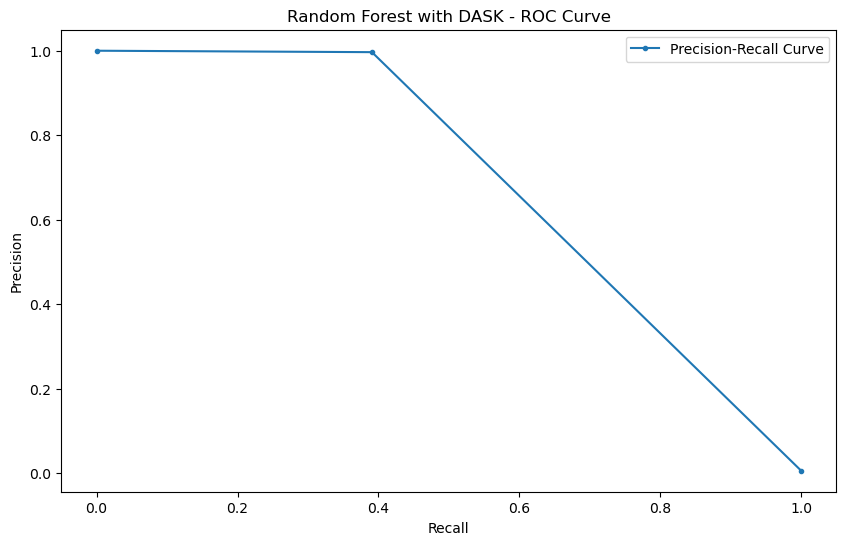

In [419]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_train, y_train_pred)
print("ROC AUC Score:", roc_auc)

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)

# Calculate the area under the Precision-Recall curve
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Display key metrics
print("Precision at various thresholds:", precision)
print("Recall at various thresholds:", recall)

# You can plot these metrics for a clearer understanding
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# Define the title
title = 'Random Forest with DASK - ROC Curve'
plt.title(title)
plt.legend()


# Use the title in the filename
filename = f"{model_specs.replace(' ', '_')}_{dataset_type}_{title.replace(' ', '_').lower()}.png"
plt.savefig(os.path.join(reports_output_dir, filename), dpi=300, bbox_inches='tight')
plt.show()





In [405]:

# Prepare the full report content
full_report = f"Accuracy: {accuracy:.4f}\n\n{clf_report}"
print(full_report)

# Define the report title and output filename
classification_report_title = 'Report'
classification_report_outputfilename = f"{model_specs}_{dataset_type}_{classification_report_title.replace(' ', '_').replace(',', '').lower()}.txt"

# Save the classification report with accuracy to a text file
with open(os.path.join(reports_output_dir, classification_report_outputfilename), 'w') as f:
    f.write(full_report)  # Writing the combined report string to the file

print(f"Classification report saved to: {os.path.join(reports_output_dir, classification_report_outputfilename)}")


Accuracy: 0.9965

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    553574
         1.0       0.99      0.14      0.25      2145

    accuracy                           1.00    555719
   macro avg       1.00      0.57      0.62    555719
weighted avg       1.00      1.00      1.00    555719

Classification report saved to: /Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/DecisionTrees/Random Forest using DASK_test_report.txt


In [ ]:
log_time("END - Random Forest with DASK Model .....  ", start_time)
start_time = time.time()

In [ ]:

# Close Dask client when done
client.close()
log_time("Closed the DASK Client", start_time)


In [407]:
import pickle
import os

if use_test_data:
    print("no model saving during test")
else:
    # Specify the output directory
    output_dir_model = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models'

    # Create a dynamic filename with .pkl extension
    model_title = 'model'
    outputfilename_model = f"{model_specs}_{model_title.replace(' ', '_').replace(',', '').lower()}.pkl"

    # Save the best model obtained from GridSearchCV
    with open(os.path.join(output_dir_model, outputfilename_model), 'wb') as model_file:
        pickle.dump(model, model_file)

    print(f"Model saved to {os.path.join(output_dir_model, outputfilename_model)}")


no model saving during test


In [406]:
import os
import time

# Assuming start_time is defined earlier in the notebook
end_time_notebook = time.time()
elapsed_time = end_time_notebook - start_time_notebook

# Print and format the notebook end time and total execution time
print(f"Notebook ended at: {time.ctime(end_time_notebook)}")
print(f"Total execution time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds")


log_time(f"{model_specs}_{dataset_type} Notebook Ended at... ", start_time_notebook)


Notebook ended at: Sun Nov  3 14:02:52 2024
Total execution time: 25 minutes and 56.38 seconds
Random Forest using DASK_test Notebook Ended at...  completed at Sun Nov  3 14:02:52 2024. Elapsed time: 25 minutes and 56.38 seconds

